# Import modules

In [1]:
%matplotlib inline
#%matplotlib notebook

#Basic stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# ML models
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer

# Regression metrics
from sklearn.metrics import explained_variance_score, median_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize tqdm progress bar
from tqdm import tqdm, tnrange, tqdm_notebook
from tqdm.auto import tqdm
tqdm.pandas(tqdm_notebook)

In [2]:
%reload_ext autoreload
%autoreload 2
# The averaged random forest model
from MTase.AverageRandomForests import AverageRF
from MTase.utils import train_test_split_data

# Functions

In [20]:
def fit_and_test_model(df, sort_to, fit_to, indep):
    """
    Creates and tests a regression model using data from `indep` as the
    independent variable and `fit_to` as the target (dependent) variable.
    Uses scikit-learn `train_test_split` to separate the data into train and 
    test groups, using 10% of the data for testing. Then fits the model to 
    the train group, and calculates statistics using the test group.
    
    Assumes the DataFrame has a column calld 'PUBCHEM_SID' with an identifier 
    unique for each molecule, but the same molecule may appear more than
    once in the data, due to different protonation states, tautomerization, 
    etc. So, before trying to build the model, filters the data to 
    keep only the first appearance of this 'PUBCHEM_SID', as ordered by the
    'sort_to' column.
    
    Parameters:
    -----------
    
    df: Pandas DataFrame
        The DataFrame with the data.
    
    sort_to: str
        Column name with the values to sort the DataFrame by. 
        
    fit_to: str
        Column name to be used in the correlation.
    
    indep: str
        Column name for the column with values for the independent variable
        
    Returns:
    --------
    A `dict` with statistics on the model. Keys:
        - "Explanined Variance Score",
        - "Mean Absolute Error",
        - "Mean SQUARED error", 
        - "MEDIAN absolute error",
        - "R^2 Score"
        
    TO-DO:
    ------
        - Use more than one column for indep, sort_to
        - use a generic column to identify molecules
    """
    
    _data = None
    columns = ['PUBCHEM_SID',sort_to, fit_to, indep]
    
    if sort_to == fit_to:
        columns = ['PUBCHEM_SID',fit_to, indep]
        
    _data = df.filter(columns,axis=1)
    
    # Sort & select data
    _data.sort_values(by=['PUBCHEM_SID',sort_to], inplace=True)
    _data.reset_index(inplace=True)
    _data.drop_duplicates(subset=['PUBCHEM_SID'], keep='first', inplace=True)
    _data.reset_index(inplace=True)
    
    # Train-test split
    # This split will return the indices for X, and the y values
    X_data = _data.index
    y_data = _data[fit_to].values
    X_train_index, X_test_index, y_train, y_test = train_test_split(X_data, y_data, test_size=0.10, shuffle=True)

    # Model
    X_train = np.array(list(_data.iloc[X_train_index][indep])).astype(int)
    X_test  = np.array(list(_data.iloc[X_test_index][indep])).astype(int)
    model = RandomForestRegressor(n_estimators=250)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    # Regression stats    
    evs  = explained_variance_score(y_test,y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    mdae = median_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    
    print("\t\tExplained Variance Score =",evs )
    print("\t\tMean Absolute Error      =",mae )
    print("\t\tMean SQUARED error       =",mse )
    print("\t\tMEDIAN absolute error    =",mdae)
    print("\t\tR^2 Score                =",r2  )
    
    res = { "Explanined Variance Score":evs,
            "Mean Absolute Error":mae,
            "Mean SQUARED error":mse, 
            "MEDIAN absolute error":mdae,
            "R^2 Score":r2}
    
    return res

In [4]:
def correlate_models(df, sort_to, fit_to, indep):
    """
    Measures the correlation between two columns in a dataframe, after
    filtering the data for repeating instances of the same molecule.
    
    Assumes the DataFrame has a column calld 'PUBCHEM_SID' with an identifier 
    unique for each molecule, but the same molecule may appear more than
    once in the data, due to different protonation states, tautomerization, 
    etc. So, before trying to correlate the data, filters the data to 
    keep only the first appearance of this 'PUBCHEM_SID', as ordered by the
    'sort_to' column.
    
    Parameters:
    -----------
    
    df: Pandas DataFrame 
        Dataframe with the data to correlate
                
    sort_to: str
        Column name with the values to sort the DataFrame by. 
        
    fit_to: str
        Column name to be used in the correlation.
    
    indep: str
        Column name for the column with values for the independent variable
        
    Returns:
    --------
    The correlation coefficient obtained by Pandas `df.corr` method.
    
    TO-DO:
    ------
        - Use more than one column for indep, sort_to
        - use a generic column to identify molecules

    """
    _data = None
    columns = ['PUBCHEM_SID',sort_to, fit_to, indep]
    
    if sort_to == fit_to:
        columns = ['PUBCHEM_SID',fit_to, indep]
        
    _data = df.filter(columns,axis=1)
    
    # sort_to & select data
    _data.sort_values(by=['PUBCHEM_SID',sort_to], inplace=True)
    _data.reset_index(inplace=True)
    _data.drop_duplicates(subset=['PUBCHEM_SID'], keep='first', inplace=True)
    _data.reset_index(inplace=True)
    
    correlation = _data[fit_to].corr(_data[indep])
    
    print(f"\tCorrelation between {fit_to} and {indep} = {correlation:0.3f}" )
    
    return correlation

# Data

In [5]:
active = pd.read_pickle("./data/active_df_fp.pkl.bz2")

In [6]:
sd_3evg_file  = "./data/dock_minSD_3evg-gdp_noH2O.csv"
opt_3evg_file = "./data/dock_minOpt_3evg-gdp_noH2O.csv"
columns = ["docking score SP","glide emodel SP","glide energy","PUBCHEM_SID","Log IC50","IC50"]
column_types = {'PUBCHEM_SID':np.int64,
                'docking score SP':np.float64,'glide emodel SP':np.float64,'glide energy':np.float64,
                'Log IC50':np.float64,'IC50':np.float64}

In [7]:
docking = pd.read_csv(sd_3evg_file,usecols=columns,dtype=column_types)

In [8]:
#active.corr()
corr = docking[['Log IC50','IC50',
              'docking score SP', 'glide emodel SP','glide energy']].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Log IC50,IC50,docking score SP,glide emodel SP,glide energy
Log IC50,1,0.95,0.02,-0.14,-0.14
IC50,0.95,1,0.025,-0.11,-0.11
docking score SP,0.02,0.025,1,0.56,0.34
glide emodel SP,-0.14,-0.11,0.56,1,0.83
glide energy,-0.14,-0.11,0.34,0.83,1


In [19]:
docking.head()

,docking score SP,glide emodel SP,glide energy,PUBCHEM_SID,Log IC50,IC50
0,-7.102,-74.883,-42.417,92764077,-4.40,39.811
1,-6.629,-76.028,-45.672,49679658,-4.70,19.953
2,-6.616,-101.751,-56.645,92763732,-5.05,8.913
3,-6.519,-91.731,-37.337,93576898,-4.65,22.387
4,-6.456,-68.044,-51.568,24782281,-4.95,11.220


# Test Dockings

In [16]:
minimizations = [{'Algorithm':'SD', 'file':sd_3evg_file},
                 {'Algorithm':'Optimal', 'file':sd_3evg_file}]

In [11]:
descriptors = ['RDKit Fingerprints', 'Morgan Fingerprints']
models = {'Dock_Sc//EModel  (SP)':{'sort':'glide emodel SP' , 'fit_to':'docking score SP'},
          'GlideE//EModel   (SP)':{'sort':'glide emodel SP' , 'fit_to':'glide energy' },
          'EModel//EModel   (SP)':{'sort':'glide emodel SP' , 'fit_to':'glide emodel SP' },
          'Dock_Sc//Dock_Sc (SP)':{'sort':'docking score SP', 'fit_to':'docking score SP'},
          'GlideE//GlideE   (SP)':{'sort':'glide energy'    , 'fit_to':'glide energy' },
          }

## Correlation to IC50

In [17]:
correlations = pd.DataFrame(columns=["Algorithm","Name", "Target","Correlation"])
for minim in tqdm(minimizations):
    _file = minim['file']
    _alg  = minim['Algorithm']
    
    active = pd.read_csv(_file,usecols=columns,dtype=column_types)
    print(f"Using {_alg} minimizations\n")
    print(50*"*")
    for indep in tqdm(['Log IC50','IC50']):
        for model in tqdm(models):
            m = models[model]
            sort = m['sort']
            fit_to = m['fit_to']
            print("\n", 30*"-")
            print(f"{indep:19s} : {model:15} : Sorted by {sort:16} : Scored by {fit_to:15}")
            corr = correlate_models(active, sort, fit_to, indep)
            
            _res = {"Algorithm":_alg,"Name":model, "Target":indep,"Correlation":corr}
            correlations = correlations.append(_res, ignore_index=True)

print("\n Done.")

Using SD minimizations

**************************************************



 ------------------------------
Log IC50            : Dock_Sc//EModel  (SP) : Sorted by glide emodel SP  : Scored by docking score SP
	Correlation between docking score SP and Log IC50 = -0.002

 ------------------------------
Log IC50            : GlideE//EModel   (SP) : Sorted by glide emodel SP  : Scored by glide energy   
	Correlation between glide energy and Log IC50 = -0.170

 ------------------------------
Log IC50            : EModel//EModel   (SP) : Sorted by glide emodel SP  : Scored by glide emodel SP
	Correlation between glide emodel SP and Log IC50 = -0.164

 ------------------------------
Log IC50            : Dock_Sc//Dock_Sc (SP) : Sorted by docking score SP : Scored by docking score SP
	Correlation between docking score SP and Log IC50 = -0.010

 ------------------------------
Log IC50            : GlideE//GlideE   (SP) : Sorted by glide energy     : Scored by glide energy   
	Correlation between glide energy and Log IC50 = -0.172



 ------------------------------
IC50                : Dock_Sc//EModel  (SP) : Sorted by glide emodel SP  : Scored by docking score SP
	Correlation between docking score SP and IC50 = 0.010

 ------------------------------
IC50                : GlideE//EModel   (SP) : Sorted by glide emodel SP  : Scored by glide energy   
	Correlation between glide energy and IC50 = -0.144

 ------------------------------
IC50                : EModel//EModel   (SP) : Sorted by glide emodel SP  : Scored by glide emodel SP
	Correlation between glide emodel SP and IC50 = -0.135

 ------------------------------
IC50                : Dock_Sc//Dock_Sc (SP) : Sorted by docking score SP : Scored by docking score SP
	Correlation between docking score SP and IC50 = 0.001

 ------------------------------
IC50                : GlideE//GlideE   (SP) : Sorted by glide energy     : Scored by glide energy   
	Correlation between glide energy and IC50 = -0.148
Using Optimal minimizations

******************************


 ------------------------------
Log IC50            : Dock_Sc//EModel  (SP) : Sorted by glide emodel SP  : Scored by docking score SP
	Correlation between docking score SP and Log IC50 = -0.002

 ------------------------------
Log IC50            : GlideE//EModel   (SP) : Sorted by glide emodel SP  : Scored by glide energy   
	Correlation between glide energy and Log IC50 = -0.170

 ------------------------------
Log IC50            : EModel//EModel   (SP) : Sorted by glide emodel SP  : Scored by glide emodel SP
	Correlation between glide emodel SP and Log IC50 = -0.164

 ------------------------------
Log IC50            : Dock_Sc//Dock_Sc (SP) : Sorted by docking score SP : Scored by docking score SP
	Correlation between docking score SP and Log IC50 = -0.010

 ------------------------------
Log IC50            : GlideE//GlideE   (SP) : Sorted by glide energy     : Scored by glide energy   
	Correlation between glide energy and Log IC50 = -0.172



 ------------------------------
IC50                : Dock_Sc//EModel  (SP) : Sorted by glide emodel SP  : Scored by docking score SP
	Correlation between docking score SP and IC50 = 0.010

 ------------------------------
IC50                : GlideE//EModel   (SP) : Sorted by glide emodel SP  : Scored by glide energy   
	Correlation between glide energy and IC50 = -0.144

 ------------------------------
IC50                : EModel//EModel   (SP) : Sorted by glide emodel SP  : Scored by glide emodel SP
	Correlation between glide emodel SP and IC50 = -0.135

 ------------------------------
IC50                : Dock_Sc//Dock_Sc (SP) : Sorted by docking score SP : Scored by docking score SP
	Correlation between docking score SP and IC50 = 0.001

 ------------------------------
IC50                : GlideE//GlideE   (SP) : Sorted by glide energy     : Scored by glide energy   
	Correlation between glide energy and IC50 = -0.148


 Done.


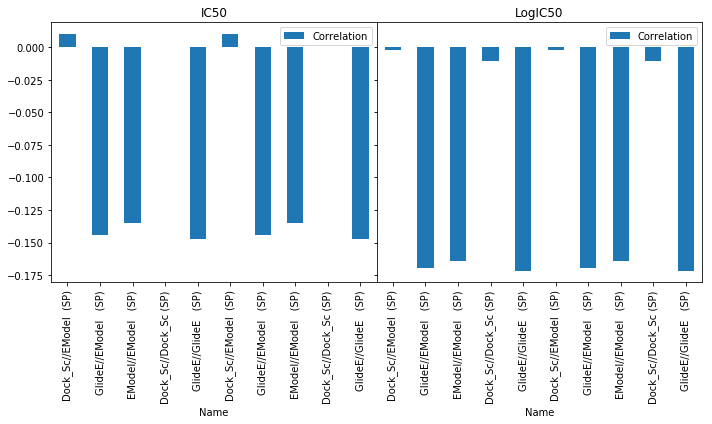

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 6))
correlations[correlations['Target'] == 'IC50'].plot.bar(x='Name', y='Correlation', title="IC50", ax=ax[0], rot=90)
correlations[correlations['Target'] == 'Log IC50'].plot.bar(x='Name', y='Correlation', title="LogIC50", ax=ax[1], rot=90)
plt.tight_layout()
fig.subplots_adjust(wspace=0)

## Modeling the Docking Results

In [22]:
# Read fingerprints
fp_file = "./data/active_df_fp.pkl.bz2"
fingerprints = pd.read_pickle(fp_file)
fingerprints = fingerprints[['PUBCHEM_SID','RDKit Fingerprints', 'Morgan Fingerprints']]

In [33]:
results = pd.DataFrame(columns=["Descriptor","Algorithm","Model","Explanined Variance Score","Mean Absolute Error",
                                "Mean SQUARED error","MEDIAN absolute error","R^2 Score"])
for minim in tqdm(minimizations):
    _file = minim['file']
    _alg  = minim['Algorithm']
    active = pd.read_csv(_file,usecols=columns,dtype=column_types)
    active = active.merge(fingerprints, how='left', on='PUBCHEM_SID')
    print(f"Using {_alg} minimizations\n")
    print(50*"*")
    
    for desc in tqdm(descriptors):
        for model in tqdm(models):
            m = models[model]
            sort_to = m['sort']
            fit_to = m['fit_to']
            print("\n", 30*"-")
            print(f"{desc:19s} : {model:15} : {sort:16} : {fit_to:15}")
            
            _res = fit_and_test_model(active, sort_to, fit_to, desc)
            _res["Algorithm"]  = _alg
            _res["Descriptor"] = desc
            _res["Model"]      = model

            results = results.append(_res, ignore_index=True)

print("\n Done.")

Using SD minimizations

**************************************************



 ------------------------------
RDKit Fingerprints  : Dock_Sc//EModel  (SP) : glide energy     : docking score SP
		Explained Variance Score = 0.12685630861090058
		Mean Absolute Error      = 0.5393845227642273
		Mean SQUARED error       = 0.648784260588225
		MEDIAN absolute error    = 0.3595766666666669
		R^2 Score                = 0.12321351444685014

 ------------------------------
RDKit Fingerprints  : GlideE//EModel   (SP) : glide energy     : glide energy   
		Explained Variance Score = 0.4425176820909621
		Mean Absolute Error      = 3.385083933797909
		Mean SQUARED error       = 17.931476296849667
		MEDIAN absolute error    = 2.625526999999991
		R^2 Score                = 0.44178796617692095

 ------------------------------
RDKit Fingerprints  : EModel//EModel   (SP) : glide energy     : glide emodel SP
		Explained Variance Score = 0.5271781367913235
		Mean Absolute Error      = 5.428216242276415
		Mean SQUARED error       = 47.42974688097595
		MEDIAN absolute error    = 4.3104


 ------------------------------
Morgan Fingerprints : Dock_Sc//EModel  (SP) : glide energy     : docking score SP
		Explained Variance Score = 0.2106286389238332
		Mean Absolute Error      = 0.48921535853658477
		Mean SQUARED error       = 0.5715093518605443
		MEDIAN absolute error    = 0.30943199999999904
		R^2 Score                = 0.20234835756116998

 ------------------------------
Morgan Fingerprints : GlideE//EModel   (SP) : glide energy     : glide energy   
		Explained Variance Score = 0.5750700706139837
		Mean Absolute Error      = 2.771020711382111
		Mean SQUARED error       = 13.679189089613889
		MEDIAN absolute error    = 2.0344699999999882
		R^2 Score                = 0.5672432162095304

 ------------------------------
Morgan Fingerprints : EModel//EModel   (SP) : glide energy     : glide emodel SP
		Explained Variance Score = 0.7426171152908098
		Mean Absolute Error      = 4.063136893379786
		Mean SQUARED error       = 27.76949243995879
		MEDIAN absolute error    = 3.16


 ------------------------------
RDKit Fingerprints  : Dock_Sc//EModel  (SP) : glide energy     : docking score SP
		Explained Variance Score = 0.0819871004873084
		Mean Absolute Error      = 0.4884703373983737
		Mean SQUARED error       = 0.4028127165451097
		MEDIAN absolute error    = 0.4142300000000001
		R^2 Score                = 0.08176139459703013

 ------------------------------
RDKit Fingerprints  : GlideE//EModel   (SP) : glide energy     : glide energy   
		Explained Variance Score = 0.4435274091970649
		Mean Absolute Error      = 3.3719122869918676
		Mean SQUARED error       = 21.855494069798706
		MEDIAN absolute error    = 2.1594655000000387
		R^2 Score                = 0.4171236281193438

 ------------------------------
RDKit Fingerprints  : EModel//EModel   (SP) : glide energy     : glide emodel SP
		Explained Variance Score = 0.4661490991546553
		Mean Absolute Error      = 5.584388432520318
		Mean SQUARED error       = 52.75025774819724
		MEDIAN absolute error    = 4.648


 ------------------------------
Morgan Fingerprints : Dock_Sc//EModel  (SP) : glide energy     : docking score SP
		Explained Variance Score = 0.21869465211735262
		Mean Absolute Error      = 0.4389248540069686
		Mean SQUARED error       = 0.3306816674082473
		MEDIAN absolute error    = 0.3444859999999985
		R^2 Score                = 0.21284874477746485

 ------------------------------
Morgan Fingerprints : GlideE//EModel   (SP) : glide energy     : glide energy   
		Explained Variance Score = 0.5692542072768894
		Mean Absolute Error      = 2.6350496276422715
		Mean SQUARED error       = 12.013332933947678
		MEDIAN absolute error    = 1.7836200000000062
		R^2 Score                = 0.567962481212724

 ------------------------------
Morgan Fingerprints : EModel//EModel   (SP) : glide energy     : glide emodel SP
		Explained Variance Score = 0.6405219371797175
		Mean Absolute Error      = 4.780400420325196
		Mean SQUARED error       = 37.06492498216525
		MEDIAN absolute error    = 3.662

In [34]:
results

,Descriptor,Algorithm,Model,Explanined Variance Score,Mean Absolute Error,Mean SQUARED error,MEDIAN absolute error,R^2 Score
0,RDKit Fingerprints,SD,Dock_Sc//EModel (SP),0.126856,0.539385,0.648784,0.359577,0.123214
1,RDKit Fingerprints,SD,GlideE//EModel (SP),0.442518,3.385084,17.931476,2.625527,0.441788
2,RDKit Fingerprints,SD,EModel//EModel (SP),0.527178,5.428216,47.429747,4.310406,0.526799
3,RDKit Fingerprints,SD,Dock_Sc//Dock_Sc (SP),0.197742,0.581749,0.523257,0.522269,0.187711
4,RDKit Fingerprints,SD,GlideE//GlideE (SP),0.672407,2.668167,11.454392,2.267485,0.672163
5,Morgan Fingerprints,SD,Dock_Sc//EModel (SP),0.210629,0.489215,0.571509,0.309432,0.202348
6,Morgan Fingerprints,SD,GlideE//EModel (SP),0.575070,2.771021,13.679189,2.034470,0.567243
7,Morgan Fingerprints,SD,EModel//EModel (SP),0.742617,4.063137,27.769492,3.164574,0.734483
8,Morgan Fingerprints,SD,Dock_Sc//Dock_Sc (SP),0.232285,0.509624,0.430244,0.391634,0.231838
9,Morgan Fingerprints,SD,GlideE//GlideE (SP),0.433783,3.269856,20.436340,2.163960,0.422939


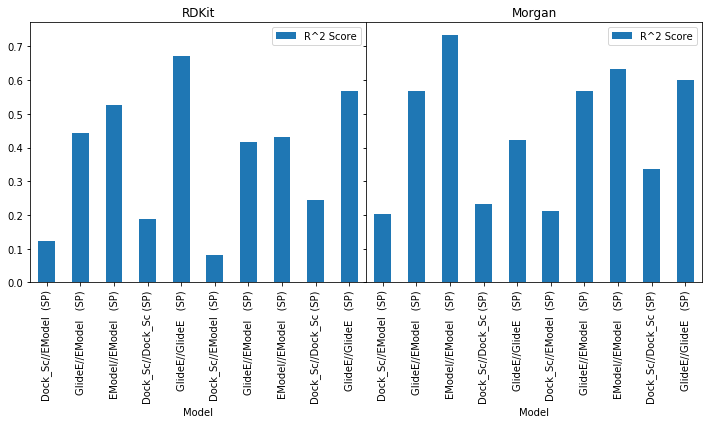

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 6))
results[results['Descriptor'] == 'RDKit Fingerprints'].plot.bar(x='Model', y='R^2 Score', title="RDKit", ax=ax[0], rot=90)
results[results['Descriptor'] == 'Morgan Fingerprints'].plot.bar(x='Model', y='R^2 Score', title="Morgan", ax=ax[1], rot=90)
plt.tight_layout()
fig.subplots_adjust(wspace=0)

# Other tests

In [ ]:
avgRF_test = AverageRF(model_type="regressor",n_forests=5,n_estimators=100, verbosity=1)
avgRF_test.fit(X_train_rdkit,y_train)

In [ ]:
avgRF_test_df = pd.DataFrame(avgRF_test.stats)
avgRF_test_df

In [ ]:
y_pred_avgRF = avgRF_test.predict(X_test_rdkit)

In [ ]:
# Regression stats
print(f"Explained Variance Score = {explained_variance_score(y_test,y_pred_avgRF):.2f}")
print(f"Mean Absolute Error      = {mean_absolute_error(y_test, y_pred_avgRF):.2f}")
print(f"Mean SQUARED error       = {mean_squared_error(y_test, y_pred_avgRF):.2f}")
print(f"MEDIAN ansolute error    = {median_absolute_error(y_test, y_pred_avgRF):.2f}")
print(f"R^2 Score                = {r2_score(y_test, y_pred_avgRF):.2f}")

In [ ]:
# Regression stats
print(f"Explained Variance Score = {explained_variance_score(y_test,y_rdkit):.2f}")
print(f"Mean Absolute Error      = {mean_absolute_error(y_test, y_rdkit):.2f}")
print(f"Mean SQUARED error       = {mean_squared_error(y_test, y_rdkit):.2f}")
print(f"MEDIAN ansolute error    = {median_absolute_error(y_test, y_rdkit):.2f}")
print(f"R^2 Score                = {r2_score(y_test, y_rdkit):.2f}")

In [ ]:
y_rdkit

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gboos_reg = GradientBoostingRegressor(n_estimators=250, max_features='sqrt')
test_model(gboos_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

In [ ]:
from sklearn.linear_model import SGDRegressor
dgr_reg = SGDRegressor(max_iter=1000, tol=1e-3)
test_model(dgr_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

In [ ]:
from sklearn.linear_model import BayesianRidge
bay_reg = BayesianRidge(n_iter=1000, normalize=True)
test_model(bay_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

In [ ]:
from sklearn.linear_model import ARDRegression
ard_reg = ARDRegression(n_iter=2000)
test_model(ard_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

In [ ]:
from sklearn.svm import SVR
svr_reg = SVR(kernel="rbf",gamma="scale", epsilon=0.05)
test_model(svr_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

In [ ]:
svr_reg.fit(X_train_rdkit, y_train)
y_svr = svr_reg.predict(X_test_rdkit)
fit_fn = np.poly1d(np.polyfit(y_test,rf_pred,1))
fit_lim = [min(y_test),max(y_test)]
plt.plot(y_test,y_svr, "b.",fit_lim,fit_fn(fit_lim),"r")
plt.xlabel("Exp. pIC50")
plt.ylabel("Calc. pIC50")
plt.title("Support Vector Regressor")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(bootstrap=False, criterion='mse',
           max_features="sqrt", n_estimators=1000, n_jobs=4, warm_start=False, 
           random_state=42)
test_model(rf_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

In [ ]:
rf_reg.fit(X_train_rdkit, y_train)
rf_pred = rf_reg.predict(X_test_rdkit)

In [ ]:
fit_fn = np.poly1d(np.polyfit(y_test,rf_pred,1))
fit_lim = [min(y_test),max(y_test)]
plt.plot(y_test,rf_pred, "b.",fit_lim,fit_fn(fit_lim),"r")
plt.xlabel("Exp. pIC50")
plt.ylabel("Calc. pIC50")
plt.title("Random Forest")

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
adab_reg = AdaBoostRegressor(base_estimator=svr_reg, n_estimators=50, loss="linear")
test_model(adab_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
adab_reg = AdaBoostRegressor(base_estimator=svr_reg, n_estimators=50, loss="exponential")
test_model(adab_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
adab_reg = AdaBoostRegressor(base_estimator=rf_reg, n_estimators=50, loss="exponential")
test_model(adab_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
adab_reg = AdaBoostRegressor(base_estimator=bay_reg, n_estimators=50, loss="linear", random_state=42)
test_model(adab_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)